In [6]:
import sys
sys.path.append('../../')
sys.path.append('../../../group-lasso/src/')
import matplotlib.pyplot as plt
import numpy as np
from stateinterpreter.MD import Loader
from stateinterpreter.classifier import CV_path
from stateinterpreter.plot import plot_cvpath, plot_states, plot_combination_cvs_relevant_features
from group_lasso import LogisticGroupLasso
from importlib import reload
from matplotlib.ticker import MaxNLocator

In [ ]:
reload(stateinterpreter.MD)
reload(stateinterpreter.classifier)
reload(stateinterpreter.plot)

In [7]:
chignolin_data_path = '../../../data/md_datasets/chignolin-unbiased/'
colvar_file = chignolin_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
# Compute descriptors from Trajectory
data = Loader(colvar_file, kbt=2.8, stride=100, _DEV=True)
data.load_trajectory(traj_dict)

Collective variables: (5248, 9)
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (5248, 783)


In [8]:
cv_list = ['deep.node-4', 'deep.node-3']
data.identify_states(cv_list, [(-1,1),(-1,1)], optimizer='brute', memory_saver=True)

DEV >>> Approximating FES
DEV >>> Finding Local Minima


  0%|          | 0/50 [00:00<?, ?it/s]

DEV >>> Basin Assignment


100%|██████████| 50/50 [00:01<00:00, 40.67it/s]


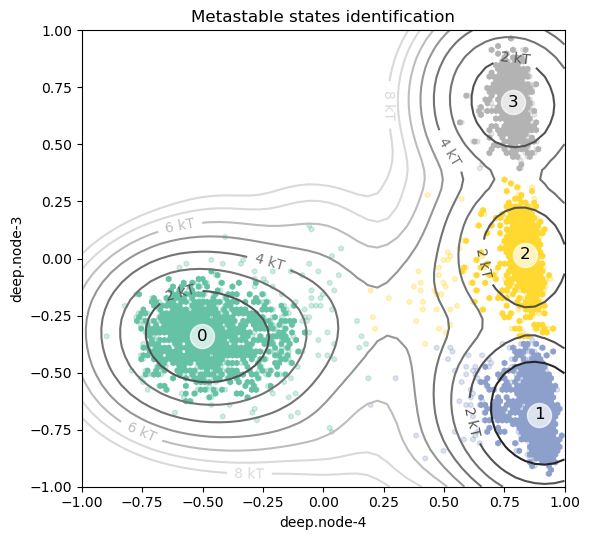

In [9]:
plot_states(data, fes_isolines=True)

In [10]:
descriptors = data.collect_data()
select_feat = 'sin_|cos_'
sample = data.sample(700, regex_filter = select_feat, states_subset=[1,2,3])

In [11]:
C_range = np.geomspace(1, 100, 25)
kwargs = {'LASSO':True, 'max_iter': 10000}
dset = sample.train_test_dataset()
n_examples = dset[0].shape[0]
C_range_in = C_range/n_examples
cvpath = CV_path(dset, sample.features, quadratic_kernel=False)

result = cvpath.compute(C_range_in,multi_class='ovr', **kwargs)

In [12]:
import re
def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return int(m.group()) if m else None

def _get_angle_groups(angle_names):
    groups = np.empty(len(angle_names), dtype=int)
    for idx, s in enumerate(angle_names):
        groups[idx] = get_trailing_number(s)
    return groups


In [13]:
groups = _get_angle_groups(sample.features)
train_in, val_in, train_out, val_out = dset

C_range = np.geomspace(100**-1, 1, 20)
kwargs = {'LASSO':True, 'max_iter': 100000}
dset = sample.train_test_dataset()
#n_examples = np.sqrt(dset[0].shape[0])
fitted_groups = []
num_groups = []
score = []
for C in C_range:
    grpLasso = LogisticGroupLasso(groups,group_reg = C, l1_reg=0, n_iter=1000, supress_warning=True)
    grpLasso.fit(train_in, train_out)
    num_groups.append(len(grpLasso.chosen_groups_))
    fitted_groups.append(grpLasso.chosen_groups_)
    score.append(grpLasso.score(val_in, val_out))

Text(0, 0.5, '# Groups')

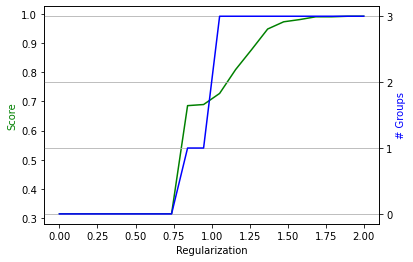

In [14]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.grid()
ax2.plot(-np.log10(C_range), num_groups, 'b-')
ax1.plot(-np.log10(C_range), score, 'g-')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.set_xlabel(r"Regularization")
ax1.set_ylabel('Score', color='g')
ax2.set_ylabel('# Groups', color='b')
#ax1.set_xlim(1/C_range[-1], 1/C_range[0])


A note on the problem to solve:
1. For regular Lasso $$ \min_{w}C\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \Vert w \Vert_{1}$$
2. For _group_ Lasso $$ \min_{w} \frac{1}{n}\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \lambda \sum_{j}  \Vert w_{j} \Vert_{2}$$

To have everything consistent $C \mapsto (\lambda n)^{-1}$. I'll use $\lambda$ as regularization parameter.